In [1]:
%%time
%load_ext autoreload
%autoreload 2

# import standard Python modules
import time 
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import torch
import re
import glob
import openai

# # Get the root path of the project
sys.path.append(os.path.abspath(".."))

# Import necessary modules from your src directory
from src.utils import timeit, encode_image
from src.processing import compute_log_spectrum_1d, extract_image_bbox, save_images
from src.api_requests import construct_payload, send_gpt_request
from src.document_generation import create_docx
from src.api_requests import single_page

from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

pylab.rcParams.update(
    {
        "legend.fontsize": "small",
        "font.size": 12,
        "figure.figsize": (6*3, 2.2*3),
        "axes.labelsize": "small",
        "axes.titlesize": "medium",
        "axes.grid": "on",
        "xtick.labelsize": "small",
        "ytick.labelsize": "small",
    }
)

print('sys.executable:', sys.executable)
print('sys.version:', sys.version, '\n')

<timed exec>:26: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display


sys.executable: /Users/ozkansafak/code/fraktur/.venv/bin/python3
sys.version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ] 

CPU times: user 830 ms, sys: 123 ms, total: 953 ms
Wall time: 953 ms


---
## Fraktur Translator

In [32]:
# Set the OpenAI API key from environment variables
openai.api_key = os.getenv("OPENAI_API_KEY")

# Set the headers for the API request
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {openai.api_key}"
}

model_name = "gpt-4o-mini-2024-07-18" # ["gpt-4o-2024-08-06", "gpt-4o-mini-2024-07-18"]
plotter = True


--------------------------------------------------
page:459 (0/83) 

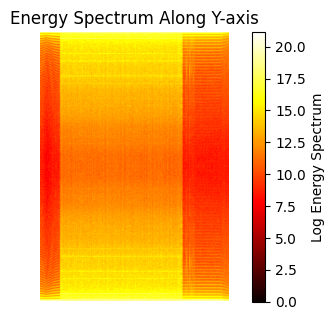

lo: 145
hi: 1094


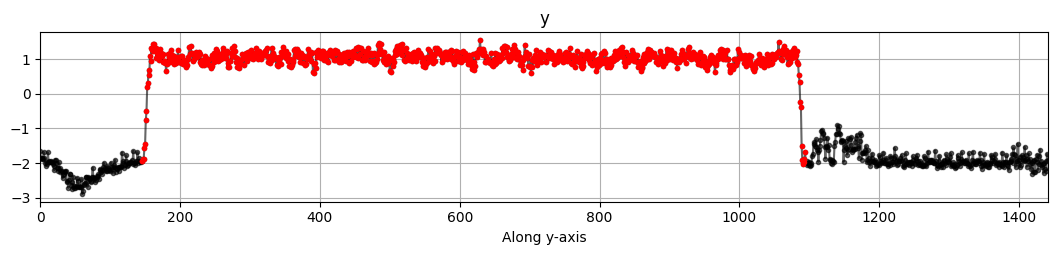

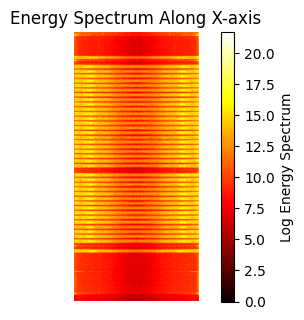

lo: 184
hi: 1701


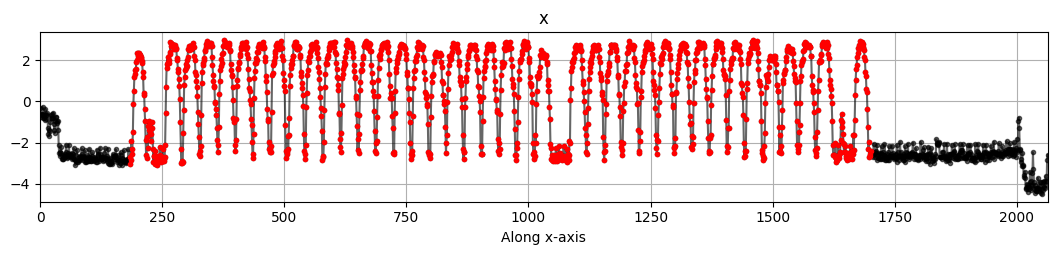

Saved ../figures/459_cropped.png
Saved ../figures/459.png


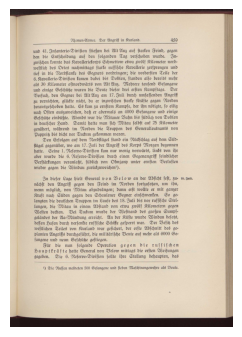

<Figure size 600x220 with 0 Axes>

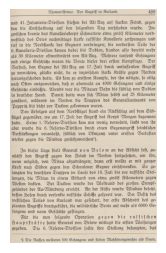

time:24.37 sec
--------------------------------------------------

und 41. Infanterie-Division fließen bei Alt Aus auf starken Feind, gegen
den die Entscheidung auf den folgenden Tag verschoben wurde. Während
dessen konnte das Kavalleriekorps Schmetto etwa dreißig Kilometer nordwestlich
des Ortes nachmittags starke russische Kavallerie beobachten und
die in die Vorflanke des Gegners vorrückenden; die vordersten Teile der
6. Kavallerie-Division kamen dabei ins Doppeln, standen also bereits mehr
als 30 Kilometer östlich von Alt Aus. Mehrere tausend Gefangene
und einige Geschütze waren die Beute dieser ersten Kampftage. Der
Versuch, den Gegner bei Alt Aus am 17. Juni durch umfassenden Angriff
zu vernichten, glitt nicht, da der unsichtbar starke Kräfte gegen Norden
herausgeschoben hatte. Es kam zu ernsten Kämpfen, der ihn nötigte, so eilig
nach Osten auszuweichen, bei der er abermals 4000 Gefangene und einige
Geschütze zurückließ. Nebenher war die Mittelbahn bis sichtbar von Doppeln
in der

In [34]:
# Folder containing the Fraktur PDF files
image_path = "../Der Weltkrieg v8 Chap 4F (in Fraktur)/*pdf"

# Get the list of PDF file paths
fnames = sorted(glob.glob(image_path))
german_texts = {}
english_texts = {}

for i, fname in enumerate(fnames[3:4]):
    total_time = 0    
    start = time.time()

    pageno = re.search(r'page_(.*?)\.pdf', fname, re.DOTALL).group(1)
    print(f"{'-'*50}\npage:{pageno} ({i}/{len(fnames)-1}) ",end="")
    
    german_text, english_text = single_page(fname, model_name, headers, plotter, pageno)
    
    german_texts[pageno] = german_text
    english_texts[pageno] = english_text
    delta = time.time() - start 
    total_time += delta
    print(f"time:{delta:.2f} sec\n{'-'*50}\n\n{german_text}\n\n{english_text}")
    print(f"\n[Runtime {int(total_time//60)} mins {(total_time - int(total_time//60)*60):.2f} sec]") 


In [13]:
folder_name = 'third_attempt'
with open(f'output/{folder_name}/english_texts.json', 'w') as f:
    json.dump(english_texts, f)
with open(f'output/{folder_name}/german_texts.json', 'w') as f:
    json.dump(german_texts, f)

create_docx(english_texts, folder_name, English='English')
create_docx(german_texts, folder_name, English='German')


``` 
1.  Upload Input folder of pdfs to blob storage.
2.  Read file from s3.
3.  FFT in y -> (x_hi, x_lo), write half_cropped_image to s3
4.  FFT in x -> (y_hi, y_lo), write cropped_image to s3
5.  Read cropped image from s3 -> encode_image -> translate and transcribe -> JSON output

```

In [23]:
# Define available GPT-4o models with pricing information
"""
models = {
    "gpt-4o-2024-08-06": {
        "price_txt": "$2.50 / 1M input tokens", 
        "price_img": "$0.001913 / 1500px^2"
    },
    "gpt-4o-mini-2024-07-18": {
        "price_txt": "$0.150 / 1M input tokens", 
        "price_img": "$0.003825 / 1500px^2"
    }
}

""";
